# Aplicação do Algoritmo LIME em radiografias torácicas
***

### Importação dos pacotes

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import numpy as 
from skimage.segmentation import mark_boundaries
!pip install lime
from lime import lime_image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

### Pré-processamento nos dados

In [4]:
# lendo os dados de um arquivo csv
dataframe = pd.read_csv('/content/drive/MyDrive/vinbigdata/train.csv')
# criando uma coluna com os caminhos relativos as imagens
dataframe['image_path'] = '/content/drive/MyDrive/vinbigdata/train/' + dataframe.image_id + '.jpg'

In [5]:
print('total de imagens disponíveis:', str(len(set(dataframe['image_path']))))

total de imagens disponíveis: 15000


In [6]:
# visualizando os casos disponíveis
dataframe['class_name'].value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [7]:
# removendo os casos não relativos a distúrbios pulmonares
dataframe = dataframe[dataframe.class_name != 'Aortic enlargement']
dataframe = dataframe[dataframe.class_name != 'Cardiomegaly']
dataframe = dataframe[dataframe.class_name != 'Other lesion']
dataframe = dataframe[dataframe.class_name != 'Consolidation']

In [8]:
# separando os casos rotulados como normais e anormais
normal_cases = dataframe[(dataframe.class_id == 14) & (dataframe.class_name == 'No finding')]
abnormal_cases = dataframe[(dataframe.class_id != 14) & (dataframe.class_name != 'No finding')]

print('total de dados após a filtração:', str(len(set(normal_cases['image_path'])) + len(set(abnormal_cases['image_path']))))

total de dados após a filtração: 13948


In [9]:
# removendo as imagens repetidas
normal_path = list(set(normal_cases['image_path']))
abnormal_path = list(set(abnormal_cases['image_path']))

# criando dataframes especifos com caminhos para as imagens e rótulos
normal_data = pd.DataFrame(normal_path, columns = ['filepath'])
normal_data['target'] = 0
abnormal_data = pd.DataFrame(abnormal_path, columns = ['filepath'])
abnormal_data['target'] = 1

In [10]:
print('quantidade de dados rotulados como normais:', len(normal_data))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 10606
quantidade de dados rotulados como anormais: 3342


In [11]:
# removendo 69% dos casos normais para balancear os dados
normal, _ = train_test_split(normal_data, test_size = 0.69, random_state = 42)

In [12]:
print('quantidade de dados rotulados como normais:', len(normal))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 3287
quantidade de dados rotulados como anormais: 3342


In [13]:
# concatenando os dataframes de casos normais e anormais
full_data = pd.concat([normal, abnormal_data])

In [14]:
# misturando todos os dados do dataframe e reiniciando os valores dos índices 
full_data = full_data.sample(frac = 1, axis = 0, random_state = 42).reset_index(drop=True)

In [15]:
# modificando o formato dos dados para float32
dict_type = {'target': 'float32'}
full_data = full_data.astype(dict_type) 

In [16]:
# separando os dados de treinamento e de teste
train_df, test_df = train_test_split(full_data, stratify = full_data['target'],
                                     test_size = 0.2, random_state = 42)

In [17]:
# separando os dados de validação dos dados de treinamento
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'],
                                           test_size = 0.2, random_state = 42)

In [18]:
# visualizando a quantidade de dados
print('quantidade de imagens de treinamento:', len(train_df['filepath']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['filepath']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['filepath']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 4242
quantidade de rótulos de treinamento: 4242
quantidade de imagens de teste: 1326
quantidade de rótulos de teste: 1326
quantidade de imagens de validação: 1061
quantidade de rótulos de validação: 1061


In [19]:
# normalizando as imagens de treinamento e aplicando aumento de dados
image_generator = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 10, zoom_range = 0.2)

# criando o gerador de imagens de treinamento 
train_generator = image_generator.flow_from_dataframe(
                                                      dataframe = train_df,
                                                      directory = '',
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      target_size = (256, 256))
# criando o gerador de imagens de validação 
valid_generator = image_generator.flow_from_dataframe(
                                                      dataframe = validation_df,
                                                      directory = '.', 
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      target_size = (256, 256))

# normalizando as imagens de teste 
test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe = test_df, 
                                                  directory = '.',
                                                  x_col = 'filepath',
                                                  y_col = 'target',
                                                  batch_size = 32,
                                                  seed = 42,
                                                  shuffle = True,
                                                  class_mode = 'raw',
                                                  target_size = (256, 256))

Found 4242 validated image filenames.
Found 1061 validated image filenames.
Found 1326 validated image filenames.


### Preparando a rede neural convolucional

In [ ]:
# baixando os pesos treinados da rede inception
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-03-04 18:28:40--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.240, 172.217.7.240, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   135MB/s    in 0.6s    

2021-03-04 18:28:41 (135 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# referenciando o local em que os pesos estão armazenados
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# carregando a arquitetura inception pré-treinada
pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

# carregando os pesos treinados com outros dados 
pre_trained_model.load_weights(local_weights_file)

# definindo as flags iniciais  
pre_trained_model.trainable = True
set_trainable = False

# para a arquitetura inception, a rede será retreinada a partir da camada 'mixed8'
for layer in pre_trained_model.layers:
    if layer.name == 'mixed8':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# visualizando a arquitetura definida
pre_trained_model.summary()

# obtendo a última camada como sendo a nomeada por 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# definindo uma camada de achatamento
x = layers.Flatten()(last_output)
# conecatando a rede uma camada com 1024 neurônios e função de ativação relu
x = layers.Dense(units = 1024, activation = 'relu')(x)     
# conecatando a rede uma camada com 128 neurônios e função de ativação relu
x = layers.Dense(units = 512, activation = 'relu')(x) 
# aplicando uma camada de dropout com uma taxa de 20% (normalização)
x = layers.Dropout(rate = 0.2)(x)                  
# adicionando uma camada de saída com um neurônio e uma função de ativação sigmoide
x = layers.Dense  (units = 1, activation = 'sigmoid')(x)           

# conecatando as camadas definidas acima com a arquitetura inception
model = Model(pre_trained_model.input, x) 

# compilando a rede 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# definindo o caminho pelo qual os pesos serão armazenados 
filepath = "transferlearning_weights.hdf5"
# callback para salvar o melhor valor dos pesos em relação ao desempenho com os dados de validação 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [ ]:
# definindo um array de callbacks
callbacks = [checkpoint]

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/experimentos/experimento1-dataset1-parte1/model2')
model2 = tf.keras.models.load_model('/content/drive/MyDrive/experimentos/experimento1-dataset2-parte1/model2')
model3 = tf.keras.models.load_model('/content/drive/MyDrive/experimentos/experimento1-dataset3-parte1/model2')

weights1 = model1.get_weights()
weights2 = model2.get_weights()
weights3 = model3.get_weights()

weights1 = np.array(weights1, dtype = object)
weights2 = np.array(weights2, dtype = object)
weights3 = np.array(weights3, dtype = object)

new_weights = (weights1 + weights2 + weights3) / 3

model.set_weights(list(new_weights))

In [ ]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 4242 // 32, 
                              validation_data = valid_generator, validation_steps = 1061 // 32,
                              callbacks = callbacks, epochs = 100)

Epoch 1/100
132/132 [==============================] - 1949s 15s/step - loss: 0.4753 - acc: 0.7857 - val_loss: 0.2766 - val_acc: 0.8759

Epoch 00001: val_acc improved from -inf to 0.87595, saving model to transferlearning_weights.hdf5
Epoch 2/100
132/132 [==============================] - 1449s 11s/step - loss: 0.2827 - acc: 0.8837 - val_loss: 0.2719 - val_acc: 0.8854

Epoch 00002: val_acc improved from 0.87595 to 0.88542, saving model to transferlearning_weights.hdf5
Epoch 3/100
132/132 [==============================] - 1412s 11s/step - loss: 0.2304 - acc: 0.8957 - val_loss: 0.2892 - val_acc: 0.8949

Epoch 00003: val_acc improved from 0.88542 to 0.89489, saving model to transferlearning_weights.hdf5
Epoch 4/100
132/132 [==============================] - 1380s 10s/step - loss: 0.1838 - acc: 0.9301 - val_loss: 0.3249 - val_acc: 0.8788

Epoch 00004: val_acc did not improve from 0.89489
Epoch 5/100
132/132 [==============================] - 1365s 10s/step - loss: 0.1728 - acc: 0.9263 - v

KeyboardInterrupt: ignored

### Salvando o modelo

In [ ]:
# carregando o melhor peso obtido para o modelo
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

In [ ]:
# salvando os dois modelos obtidos durante o treinamento
model.save('model1')
best_model.save('model2')

INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets


In [20]:
# carregando o melhor modelo para realização de testes de desempenho
model = tf.keras.models.load_model('/content/drive/MyDrive/experimentos/experimento2-dataset4/model2')

In [ ]:
model.evaluate(test_generator)

42/42 [==============================] - 577s 13s/step - loss: 0.1656 - acc: 0.9412


[0.16561754047870636, 0.9411764740943909]

### Métricas de avaliação do modelo

In [23]:
# carregando os dados de teste
for i in range(0, 42):
  (x1, y1) = test_generator[i]
  if i == 0:
    x, y = x1, y1
  else:
    x = np.concatenate((x, x1))
    y = np.concatenate((y, y1))y1))

In [ ]:
# realizando a predição para os dados de teste
predict = model.predict(x)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

def thresholds(limiar, predict):
  '''predição para diferentes thresholds'''

  predict_ = []
  for i in predict:
    if i > limiar:
      predict_.append(1)
    else:
      predict_.append(0)
  
  return predict_

def precision_recall_accuracy_curve(predict, y):
  ''' Relaciona a curva da Precisão, Sensibilidade e Acurácia em relação a diferentes Thresholds'''

  limiares = np.arange(0, 1, 0.05)
  predicts = []
  precisions = []
  recalls = []
  accuracy = []
  flag = 0
  for i in limiares:
    predicts.append(thresholds(i, predict))
    precisions.append(precision_score(predicts[flag], y))
    recalls.append(recall_score(predicts[flag], y))
    accuracy.append(accuracy_score(predicts[flag], y))
    flag += 1
  
  return precisions, recalls, accuracy

def plot_precision_recall_accuracy_curve(precisions, recalls, accuracy):
  '''Plotando a curva de Precisão, Sensibilidade e Acurácia'''

  plt.figure(figsize = (10,5))
  plt.plot(np.arange(0, 1, 0.05), precisions, label = 'Precision')
  plt.plot(np.arange(0, 1, 0.05), recalls, label = 'Recall')
  plt.plot(np.arange(0, 1, 0.05), accuracy, label = 'Accuracy')
  plt.title('Precisão, Sensibilidade e Acurácia para diferentes Thresholds')
  plt.xlabel('Thresholds')
  plt.legend()
  plt.savefig('curve-analysis')

  return None

def best_metrics(threshold, predict, y):
  '''Melhores valores para o threshold escolhido'''

  predict_ = thresholds(threshold, predict)
  print('Matriz de Confusão:\n', confusion_matrix(predict_, y))
  print('Acurácia:', accuracy_score(predict_, y))
  print('Precisão', precision_score(predict_, y))
  print('Sensibilidade:', recall_score(predict_, y)) 
  print('F1_Score:', f1_score(predict_, y))

  return None

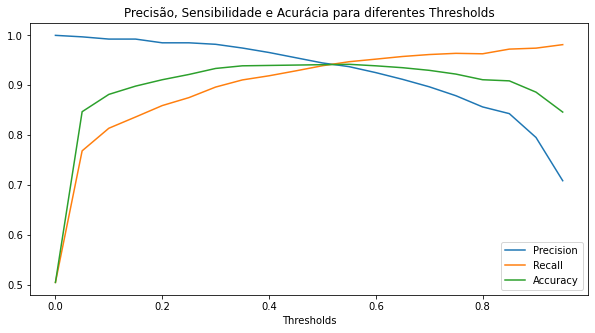

In [ ]:
# plotando a curva da Precisão, Sensibilidade e Acurácia 
precisions, recalls, accuracy = precision_recall_accuracy_curve(predict, y)
plot_precision_recall_accuracy_curve(precisions, recalls, accuracy)

In [ ]:
# analisando as melhores métricas encontradas para o modelo
best_metrics(threshold = 0.55, predict = predict, y = y)

Matriz de Confusão:
 [[622  42]
 [ 35 627]]
Acurácia: 0.9419306184012066
Precisão 0.9372197309417041
Sensibilidade: 0.947129909365559
F1_Score: 0.9421487603305786


### Algoritmo LIME (Áreas de ativação de classe)


image predict: [[0.01143354]]
real label: 0.0


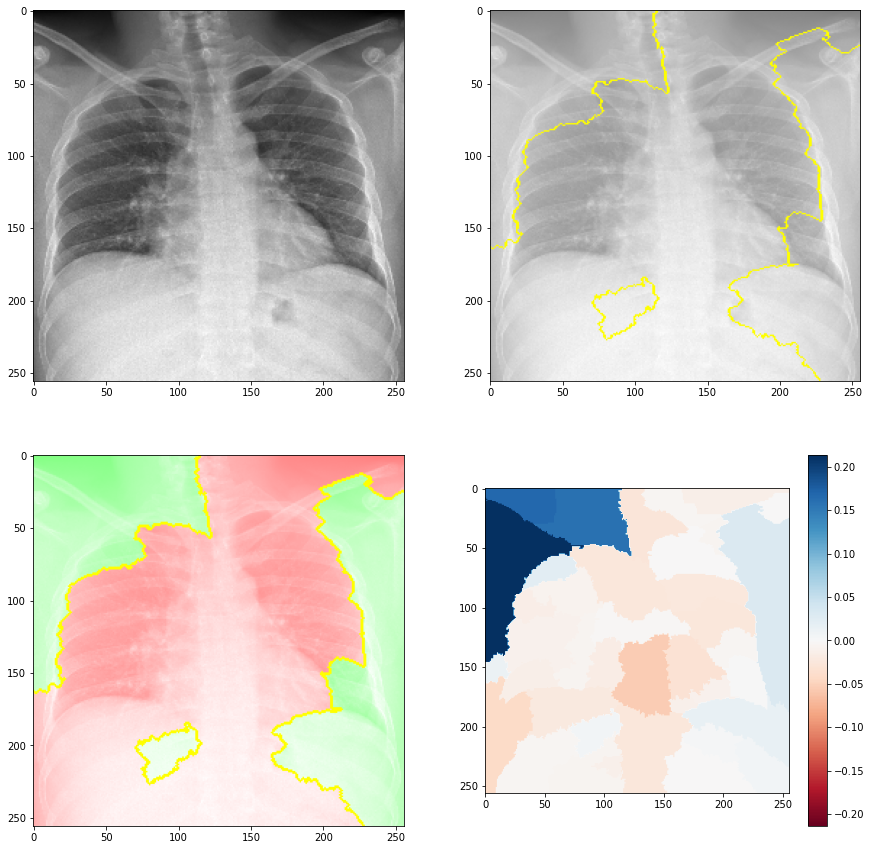

In [239]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(x[1].astype('double'), model.predict, 
                                         top_labels = 1, hide_color=0, num_samples=3000)

print('image predict: {}'.format(model.predict(x[1:2])))
print('real label: {}'.format(y[1]))

plt.figure(figsize = (15, 15))

plt.subplot(2, 2, 1)
plt.imshow(x[1])

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, 
                                            num_features=50, hide_rest=False)
plt.subplot(2, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=50, hide_rest=False)
plt.subplot(2, 2, 3)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

ind =  explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

plt.subplot(2, 2, 4)
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()


image predict: [[0.3304386]]
real label: 1.0


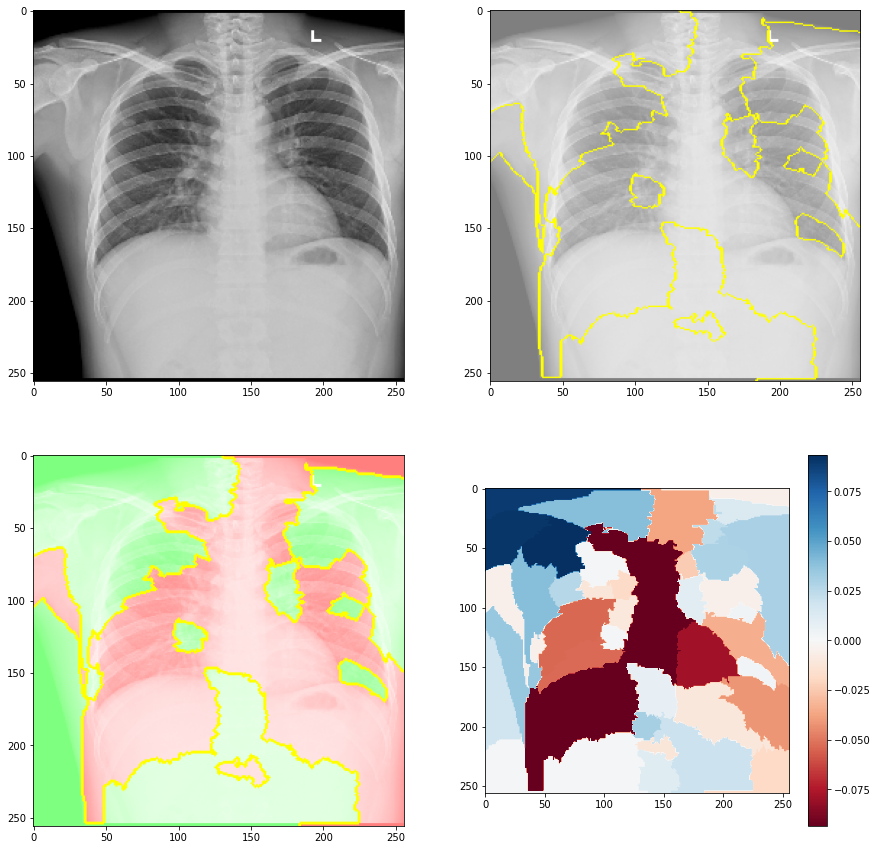

In [240]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(x[500].astype('double'), model.predict, 
                                         top_labels = 1, hide_color=0, num_samples=3000)

print('image predict: {}'.format(model.predict(x[500:501])))
print('real label: {}'.format(y[500]))

plt.figure(figsize = (15, 15))

plt.subplot(2, 2, 1)
plt.imshow(x[500])

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, 
                                            num_features=50, hide_rest=False)
plt.subplot(2, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=50, hide_rest=False)
plt.subplot(2, 2, 3)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

ind =  explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

plt.subplot(2, 2, 4)
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

image predict: [[0.99999905]]
real label: 1.0


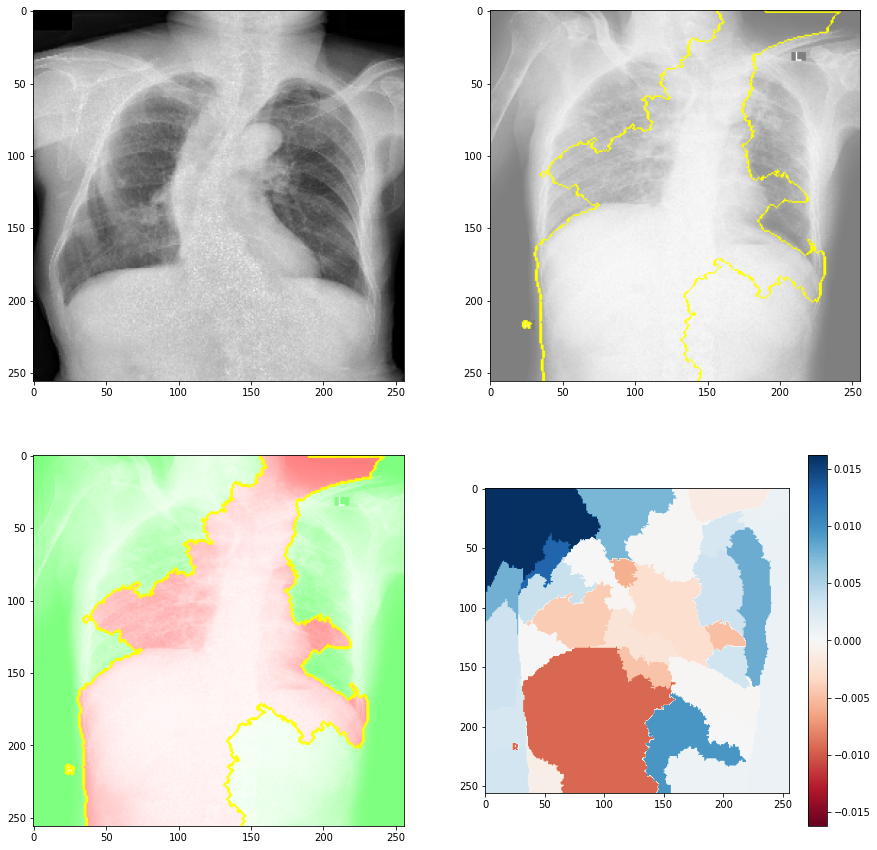

In [264]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(x[80].astype('double'), model.predict, 
                                         top_labels = 1, hide_color=0, num_samples=3000)

print('image predict: {}'.format(model.predict(x[80:81])))
print('real label: {}'.format(y[80]))

plt.figure(figsize = (15, 15))

plt.subplot(2, 2, 1)
plt.imshow(x[80])

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, 
                                            num_features=50, hide_rest=False)
plt.subplot(2, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=50, hide_rest=False)
plt.subplot(2, 2, 3)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

ind =  explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

plt.subplot(2, 2, 4)
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()


image predict: [[0.9999503]]
real label: 1.0


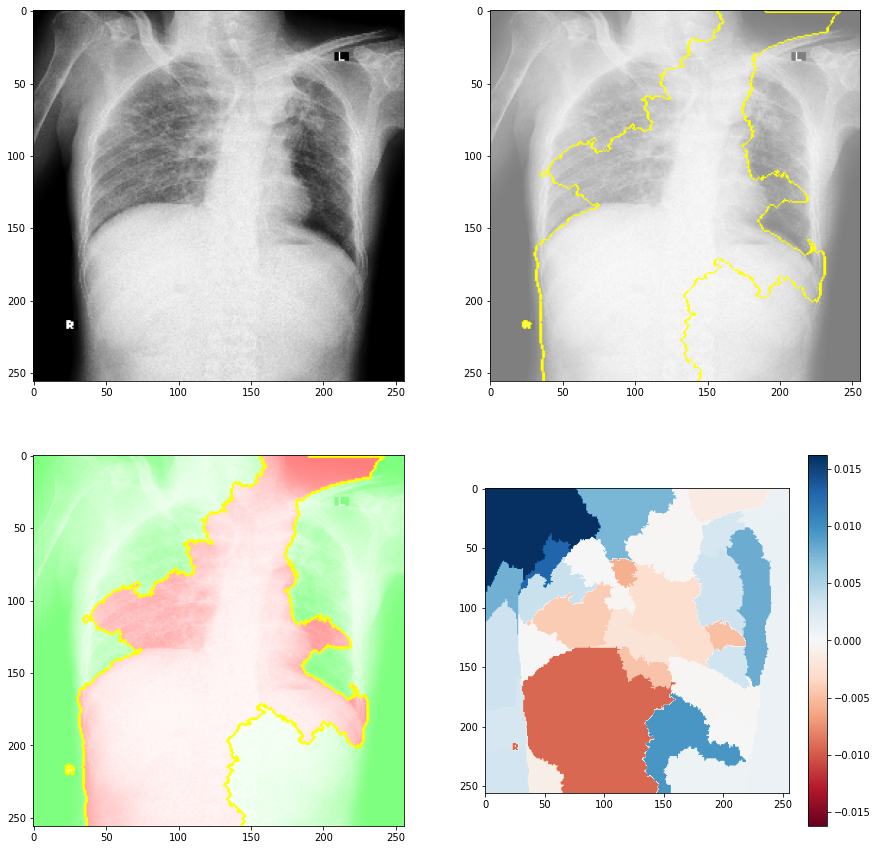

In [261]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(x[942].astype('double'), model.predict, 
                                         top_labels = 1, hide_color=0, num_samples=3000)

print('image predict: {}'.format(model.predict(x[942:943])))
print('real label: {}'.format(y[942]))

plt.figure(figsize = (15, 15))

plt.subplot(2, 2, 1)
plt.imshow(x[942])

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, 
                                            num_features=50, hide_rest=False)
plt.subplot(2, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=50, hide_rest=False)
plt.subplot(2, 2, 3)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

ind =  explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

plt.subplot(2, 2, 4)
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()